In [1]:
# We import some custom functions
from scripts.Utils import *

# We import the libraries
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
import xgboost as xgb
from hyperopt import fmin, tpe, hp, Trials

We start by taking a look at the original fact table

In [2]:
df_original = pd.read_csv('src/sales_train.csv')

In [3]:
df_original.shape

(2935849, 6)

In [4]:
df_original.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


# Merges

To recover all the useful information, we merge the fact table **sales_train** with the other dimensions

In [5]:
# We read all the dataframes
df_sales = df_original.copy()

In [6]:
df_shops = pd.read_csv('src/shops.csv')
df_categories = pd.read_csv('src/item_categories.csv')
df_items = pd.read_csv('src/items.csv')

In [7]:
# We join the information between the categories and the items
df_categories_items = df_categories.merge(df_items, how='left', left_on='item_category_id', right_on='item_category_id')

In [8]:
# Firstly, we recover the information from the shops dimension, secondly from the categories and the items dimensions
df = df_sales.merge(df_shops, how='left', left_on='shop_id', right_on='shop_id')
df = df.merge(df_categories_items, how='left', left_on='item_id', right_on='item_id')

In [9]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_category_name,item_category_id,item_name
0,02.01.2013,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,37,ЯВЛЕНИЕ 2012 (BD)
1,03.01.2013,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",Музыка - Винил,58,DEEP PURPLE The House Of Blue Light LP
2,05.01.2013,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум""",Музыка - Винил,58,DEEP PURPLE The House Of Blue Light LP
3,06.01.2013,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",Музыка - Винил,58,DEEP PURPLE Who Do You Think We Are LP
4,15.01.2013,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства,56,DEEP PURPLE 30 Very Best Of 2CD (Фирм.)


In [10]:
df = df.drop_duplicates()

In [11]:
df.shape

(2935843, 10)

Now that we have all the potential useful features for the fact table, we can start to explore it. Of course, we already observe that many descriptions are in Cyrillic, which is confusing

# Exploratory Data Analysis I (EDA I)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935843 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                object 
 1   date_block_num      int64  
 2   shop_id             int64  
 3   item_id             int64  
 4   item_price          float64
 5   item_cnt_day        float64
 6   shop_name           object 
 7   item_category_name  object 
 8   item_category_id    int64  
 9   item_name           object 
dtypes: float64(2), int64(4), object(4)
memory usage: 246.4+ MB


In [13]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2.93584e+06,2.93584e+06,2.93584e+06,2.93584e+06,2.93584e+06,2.93584e+06
mean,14.5699,33.0017,10197.2,890.853,1.24264,40.0014
std,9.42299,16.227,6324.29,1729.8,2.61884,17.1008
min,0,0,0,-1,-22,0
25%,7,22,4476,249,1,28
50%,14,31,9343,399,1,40
75%,23,47,15684,999,1,55
max,33,59,22169,307980,2169,83


We take a look at the **date** column taking into account the description of **date_block_num** that we found on the Kaggle webpage

In [14]:
df[df['date_block_num']==0]['date']

0         02.01.2013
1         03.01.2013
2         05.01.2013
3         06.01.2013
4         15.01.2013
             ...    
115685    19.01.2013
115686    18.01.2013
115687    26.01.2013
115688    31.01.2013
115689    07.01.2013
Name: date, Length: 115689, dtype: object

In [15]:
df[df['date_block_num']==33]['date']

2882335    23.10.2015
2882336    05.10.2015
2882337    02.10.2015
2882338    12.10.2015
2882339    04.10.2015
              ...    
2935844    10.10.2015
2935845    09.10.2015
2935846    14.10.2015
2935847    22.10.2015
2935848    03.10.2015
Name: date, Length: 53514, dtype: object

We also take a look at the item_price

In [16]:
len(df[df['item_price']==-1])

1

We use our exploratory custom functions to study more in depth the statistical properties of the features

In [17]:
value_counts_csv(df)
count_nulls(df)
col_names = columns_list_except(df, ['shop_name', 'item_name', 'item_category_name'])
hist_boxplot(df[col_names])

## - First Remarks and ideas for each column: individual features

- First of all, there are **no null values** in this dataset

- **date**: 34 consecutive possible months for each item. The minimum (month, year) is Octuber 2013 and the maximum is Octuber 2015.
- **date_block_num**: minimum is 0 and maximum 33. By the definition of this column, this is strictly connected to the date column. We observe that for each value we can have a minimum of 50k items and a maximum of 143k
- **shop_id**: there are 60 different shops with sales data. We observe that the number of observations per shop goes from 0.3k to 235k. This suggests that some particular shops are able to manage many products (maybe they are bigger shops actually)
- **item_id**: we have 21807 different items. We observe that the item_id 20949 is more popular than the others by far. It is about the 1% of our observations
- **item_price**: for sure, looking at the boxplot, it is evident that there are some outliers. Indeed the mean which is 890 is very different from the median (390) and moreover the maximum value is bigger than 300k. There is also an observation with price equal to -1 
- **item_cnt_day**: almost the 90% of our observations has item_cnt_day equal to 1. Looking at the charts, we see that we have a lot of outliers and some negative values
- **item_category_id**: we have 84 distinct categories. Among them, there are three much more popular than the others. The category_id 40 has almost the 20% of the total observations. 
- **shop_name**: all the names are in Cyrillic. We could think of translating them to English to get some insights. We have the feeling that the name of the shop always contains the name of the city
- **item_name**: many names are in Cyrillic. Also in this case, we could think of translating them to English to get some insights

# Feature Engineering I

In [18]:
# item_price with negative values
df[df['item_price']<=0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_category_name,item_category_id,item_name
484683,15.05.2013,4,32,2973,-1.0,1.0,"Москва ТЦ ""Серебряный Дом""",Игры - PS3,19,"DmC Devil May Cry [PS3, русские субтитры]"


- Luckily, it is just one raw in the entire dataset. Clearly it is an error due to the registration of the price on that day. We take a look at the prices for this item during other days in the same shop

In [19]:
df[(df['item_id']==2973) & (df['shop_id']==32) & (df['item_price']>0)][['item_price', 'date']]

,item_price,date
67427,2499.0,29.01.2013
67428,2499.0,25.01.2013
67429,2499.0,22.01.2013
67430,2499.0,21.01.2013
67431,2499.0,18.01.2013
67432,2499.0,17.01.2013
67433,2499.0,15.01.2013
187844,2499.0,05.02.2013
187845,2499.0,14.02.2013
484682,1249.0,23.05.2013


- Only in two obcasions that price has been cutted at the half, probably for a special 50% discount
- Since a discount like this seems to be as something very rare and special, we decide to replace the negative value with the full price

In [20]:
df['item_price'] = np.where(df['item_price']==-1, 
                            2499.0, 
                            df['item_price'])

In [21]:
# outliers for item_price with > 300k
df[df['item_price']>300000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_category_name,item_category_id,item_name
1163158,13.12.2013,11,12,6066,307980.0,1.0,Интернет-магазин ЧС,Программы - Для дома и офиса,75,Radmin 3 - 522 лиц.


In [22]:
df[(df['item_id']==6066) & (df['shop_id']==12) & (df['item_price']<300000)][['item_price', 'date']]

,item_price,date


In [23]:
df[(df['item_id']==6066) & (df['item_price']<300000)][['item_price', 'date']]

,item_price,date


- This item has been sold in one shop only once with a price that seems to be not reasonable
- Therefore, we proceed to eliminate this row from the dataset

In [24]:
df = df[df['item_id'] != 6066]

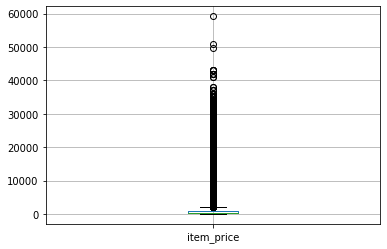

In [25]:
df.boxplot(column='item_price')

In [26]:
df[df['item_price']>45000]['item_price'].value_counts().sort_index(ascending=False)

59200.0    1
50999.0    1
49782.0    1
Name: item_price, dtype: int64

- Looking at the boxplot, we can deduce that there are 3 isolated outliers above 45k. It seems like they do not represent the real price strategy of the company that we are analizing. Probably someone made a mistake registering that price or it is a strange product with a very flexible range price
- Therefore, without additional information, we decide to eliminate them

In [27]:
df = df[df['item_price']<=45000]

In [28]:
df.shape

(2935839, 10)

In [29]:
# item_cnt_day negative
df[df['item_cnt_day']<0]['item_cnt_day'].value_counts()

-1.0     7252
-2.0       78
-3.0       14
-5.0        4
-4.0        3
-6.0        2
-9.0        1
-16.0       1
-22.0       1
Name: item_cnt_day, dtype: int64

- We interpret the negative values in item_cnt_day as the number of returned copies for that specific item, in that specific shop and on that specific day 
- According to this, we decide to keep those values and not to treat them as outliers. The monthly amount of sold copies for a particular item will be the algebraic sum of item_cnt_day

In [30]:
# item_cnt_day outliers
df[df['item_cnt_day']>900]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_category_name,item_category_id,item_name
2326930,15.01.2015,24,12,20949,4.000000,1000.0,Интернет-магазин ЧС,"Подарки - Сумки, Альбомы, Коврики д/мыши",71,Фирменный пакет майка 1С Интерес белый (34*42)...
2909818,28.10.2015,33,12,11373,0.908714,2169.0,Интернет-магазин ЧС,Доставка товара,9,Доставка до пункта выдачи (Boxberry)


- Looking at the boxplot, we observe that there are two values above 1000 of item_cnt_day that are isolated. 
- We took the corresponing item_name and using Google translate we found the following meanings: "Фирменный пакет майка 1С Интерес белый" means "Corporate package T-shirt 1C Interest white" and "Доставка товара" means "delivery of goods"
- This gives us an idea that these rows represent very particular orders during some particular events
- Therefore, we decide to eliminate them

In [31]:
df = df[df['item_cnt_day']<=900]

- Finally, we observe that the first word before either "-" or a white space or a "!" in the shop_name column represents the name of a city.
- Because of this, we create a column city

In [32]:
df['city'] = df['shop_name'].str.split(" ").str[0]
df['city'] = df['city'].str.split("-").str[0]
df['city'] = df['city'].str.split("!").str[-1]

In [33]:
# We check the names of the cities
df['city'].value_counts()

Москва          996633
Якутск          204404
СПб             148534
Воронеж         144151
Химки           143479
Тюмень          125453
Уфа              96423
Красноярск       76177
Самара           75421
Чехов            69573
Сергиев          66321
Н.Новгород       64197
Курск            63911
РостовНаДону     59664
Калуга           59511
Сургут           56695
Казань           54803
Коломна          52734
Омск             46013
Ярославль        42108
Новосибирск      39944
Волжский         38242
Вологда          38179
Цифровой         34769
Интернет         34689
Адыгея           25991
Балашиха         25532
Жуковский        21896
Томск            21612
Мытищи            5027
Выездная          3751
Name: city, dtype: int64

# EDA II: Study of the pairs (shop_id, item_id)

- We check if all the pairs (shop_id, item_id) that we have on the test.csv actually exist in our dataframe and if also the converse is true or not

In [34]:
df_test = pd.read_csv('src/test.csv')
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [35]:
df_test = df_test[['shop_id', 'item_id']]

In [36]:
# We use the custom function joining_field to represent the pairs (shop_id, item_id) in our datasets
df_test = joining_fields(df_test, 'shop_id', 'item_id', 'joined_fields')
df = joining_fields(df, 'shop_id', 'item_id', 'joined_fields')

In [37]:
# check if the pairs of df_test exist in df
comparing_columns(df, df_test, 'joined_fields', 'joined_fields')

True     111404
False    102796
Name: Match, dtype: int64


0          True
1         False
2          True
3          True
4         False
          ...  
214195     True
214196    False
214197     True
214198    False
214199     True
Name: Match, Length: 214200, dtype: bool

- So actually we will need to predict item_cnt_day for a lot of pairs (shop_id, item_id) that our model will see for the first time

In [38]:
df_test.head()

,shop_id,item_id,joined_fields,Match
0,5,5037,5_5037,True
1,5,5320,5_5320,False
2,5,5233,5_5233,True
3,5,5232,5_5232,True
4,5,5268,5_5268,False


In [39]:
df[(df['shop_id']==5) & (df['item_id']==5320)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_category_name,item_category_id,item_name,city,joined_fields


In [40]:
# For completeness we check the converse too
comparing_columns(df_test, df, 'joined_fields', 'joined_fields')

False    1711406
True     1224431
Name: Match, dtype: int64


0           True
1          False
2          False
3          False
4          False
           ...  
2935844     True
2935845     True
2935846     True
2935847     True
2935848     True
Name: Match, Length: 2935837, dtype: bool

In [41]:
df.drop('Match', axis = 1, inplace=True)

# Feature Engineering II

We want to look the data at a year-month level. Therefore, we perform a group by year-month where we sum the **item_cnt_day** and we take the median for the **item_price**

In [42]:
df['month'] = df['date'].str.split(".").str[1]
df['year'] = df['date'].str.split(".").str[2]
df.drop('date', axis=1, inplace=True)

In [43]:
agg_dict = {'item_cnt_day': 'sum', 'item_price': np.median}
col_names = columns_list_except(df, ['item_price', 'item_cnt_day'])
df = df.groupby(col_names, as_index=False).agg(agg_dict)

df.head()

,date_block_num,shop_id,item_id,shop_name,item_category_name,item_category_id,item_name,city,joined_fields,month,year,item_cnt_day,item_price
0,0,0,32,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,40,1+1,Якутск,0_32,01,2013,6.0,221.0
1,0,0,33,"!Якутск Орджоникидзе, 56 фран",Кино - Blu-Ray,37,1+1 (BD),Якутск,0_33,01,2013,3.0,347.0
2,0,0,35,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,40,10 ЛЕТ СПУСТЯ,Якутск,0_35,01,2013,1.0,247.0
3,0,0,43,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,40,100 МИЛЛИОНОВ ЕВРО,Якутск,0_43,01,2013,1.0,221.0
4,0,0,51,"!Якутск Орджоникидзе, 56 фран",Музыка - MP3,57,100 лучших произведений классики (mp3-CD) (Dig...,Якутск,0_51,01,2013,2.0,128.5


In [44]:
df.drop(['month', 'year'], axis=1, inplace=True)

If an item does not appear in a shop during a month, we create a new observation filling that row with **item_cnt_day** equal to 0 and **item_price** equal to the price of the month before

In [45]:
col_names = columns_list_except(df, ['item_price', 'month', 'year', 'date_block_num', 'item_cnt_day'])

df_pivoted_stacked = df.drop(['item_price'], axis=1).pivot_table(["item_cnt_day"], col_names, 'date_block_num').stack(1, dropna=False)
df_pivoted_stacked = df_pivoted_stacked.reset_index()
df_pivoted_stacked.head(10)

df_merged = df_pivoted_stacked.merge(df, on=df_pivoted_stacked.columns.tolist(), how='left')


med = df_merged.groupby('joined_fields')['item_price'].transform('median')
df_merged.shape

df_merged['item_price'].fillna(med, inplace=True)
df_merged['item_cnt_day'].fillna(0, inplace=True)

In [46]:
df_merged.head(10)

,shop_id,item_id,shop_name,item_category_name,item_category_id,item_name,city,joined_fields,date_block_num,item_cnt_day,item_price
0,0,30,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,40,007: КООРДИНАТЫ «СКАЙФОЛЛ»,Якутск,0_30,0,0.0,265.0
1,0,30,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,40,007: КООРДИНАТЫ «СКАЙФОЛЛ»,Якутск,0_30,1,31.0,265.0
2,0,30,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,40,007: КООРДИНАТЫ «СКАЙФОЛЛ»,Якутск,0_30,2,0.0,265.0
3,0,30,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,40,007: КООРДИНАТЫ «СКАЙФОЛЛ»,Якутск,0_30,3,0.0,265.0
4,0,30,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,40,007: КООРДИНАТЫ «СКАЙФОЛЛ»,Якутск,0_30,4,0.0,265.0
5,0,30,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,40,007: КООРДИНАТЫ «СКАЙФОЛЛ»,Якутск,0_30,5,0.0,265.0
6,0,30,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,40,007: КООРДИНАТЫ «СКАЙФОЛЛ»,Якутск,0_30,6,0.0,265.0
7,0,30,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,40,007: КООРДИНАТЫ «СКАЙФОЛЛ»,Якутск,0_30,7,0.0,265.0
8,0,30,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,40,007: КООРДИНАТЫ «СКАЙФОЛЛ»,Якутск,0_30,8,0.0,265.0
9,0,30,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,40,007: КООРДИНАТЫ «СКАЙФОЛЛ»,Якутск,0_30,9,0.0,265.0


- For every (item, shop) we inserted a row for every month in case it was absent. The item_price has been filled with median and item_cnt_day with 0

## Strategy I: Benchmark

- As first and **naive** strategy, we are going to assume that a shop will sell an item at the same amount of the month before
- We expect that the next strategies will **outperform** the benchmark approach by far

In [47]:
df_predicted = df_merged[['joined_fields', 'date_block_num', 'item_cnt_day']]
df_predicted = df_predicted[df_predicted['date_block_num'] == 32]

In [48]:
df_true_value = df_merged[['joined_fields', 'date_block_num', 'item_cnt_day']]
df_true_value = df_true_value[df_true_value['date_block_num'] == 33]

In [49]:
df_benchmark = df_predicted.merge(df_true_value, on='joined_fields', how='inner', suffixes=['_predicted','_true_value'])

In [50]:
df_benchmark.head()

,joined_fields,date_block_num_predicted,item_cnt_day_predicted,date_block_num_true_value,item_cnt_day_true_value
0,0_30,32,0.0,33,0.0
1,0_31,32,0.0,33,0.0
2,0_32,32,0.0,33,0.0
3,0_33,32,0.0,33,0.0
4,0_35,32,0.0,33,0.0


In [51]:
# Now we evaluate the benchmark prediction
r2 = r2_score(df_benchmark['item_cnt_day_predicted'], df_benchmark['item_cnt_day_true_value'])

In [52]:
mse = mean_squared_error(df_benchmark['item_cnt_day_predicted'], df_benchmark['item_cnt_day_true_value'])
rmse = mean_squared_error(df_benchmark['item_cnt_day_predicted'], df_benchmark['item_cnt_day_true_value']) ** 0.5

In [53]:
print('The R2 score is: ', r2)
print('The mean square error is: ', mse)
print('The root mean square error is: ', rmse)

The R2 score is:  0.02676808108045603
The mean square error is:  23.555287288297443
The root mean square error is:  4.853378955768593


- We observe that the **r2 score** is extremely low
- the **RMSE** on the other hand is quite acceptable

In [54]:
error_benchmark = df_benchmark['item_cnt_day_predicted'] - df_benchmark['item_cnt_day_true_value']

(array([1.0000e+00, 1.7000e+01, 4.2409e+05, 4.0000e+00, 3.0000e+00,
        3.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([-500. , -285.6,  -71.2,  143.2,  357.6,  572. ,  786.4, 1000.8,
        1215.2, 1429.6, 1644. ]),
 <a list of 10 Patch objects>)

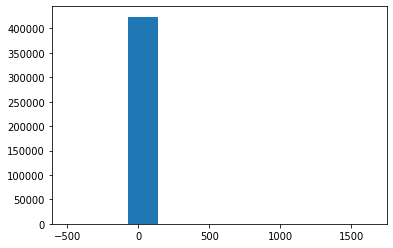

In [55]:
plt.hist(error_benchmark)

- most of the errors are around 0, which is good. However, we are also skewed towards right
- maybe in general people spend more money on September than October?

(array([8.10000e+01, 0.00000e+00, 7.70000e+01, 0.00000e+00, 0.00000e+00,
        1.16000e+02, 0.00000e+00, 0.00000e+00, 1.82000e+02, 0.00000e+00,
        0.00000e+00, 3.07000e+02, 0.00000e+00, 4.59000e+02, 0.00000e+00,
        0.00000e+00, 1.03400e+03, 0.00000e+00, 0.00000e+00, 3.28000e+03,
        0.00000e+00, 0.00000e+00, 1.66920e+04, 0.00000e+00, 0.00000e+00,
        3.79707e+05, 0.00000e+00, 1.61530e+04, 0.00000e+00, 0.00000e+00,
        3.13400e+03, 0.00000e+00, 0.00000e+00, 9.95000e+02, 0.00000e+00,
        0.00000e+00, 4.80000e+02, 0.00000e+00, 2.53000e+02, 0.00000e+00,
        0.00000e+00, 1.39000e+02, 0.00000e+00, 0.00000e+00, 1.02000e+02,
        0.00000e+00, 0.00000e+00, 7.00000e+01, 0.00000e+00, 5.20000e+01]),
 array([-9.  , -8.64, -8.28, -7.92, -7.56, -7.2 , -6.84, -6.48, -6.12,
        -5.76, -5.4 , -5.04, -4.68, -4.32, -3.96, -3.6 , -3.24, -2.88,
        -2.52, -2.16, -1.8 , -1.44, -1.08, -0.72, -0.36,  0.  ,  0.36,
         0.72,  1.08,  1.44,  1.8 ,  2.16,  2.52,  2.88

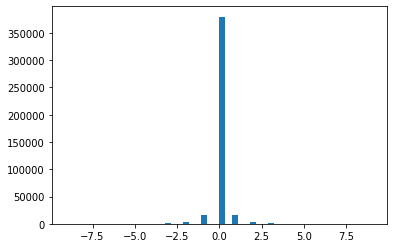

In [56]:
plt.hist(error_benchmark[abs(error_benchmark)<10], bins=50)

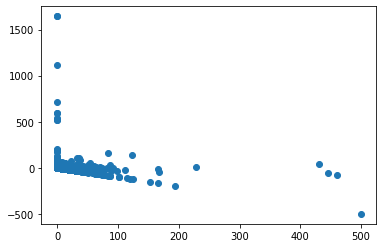

In [57]:
plt.scatter(df_benchmark['item_cnt_day_true_value'], error_benchmark)

In [58]:
# count of errors in percentages
perc_errors_benchmark = abs(error_benchmark).value_counts().to_frame()
perc_errors_benchmark['value'] = perc_errors_benchmark.index
perc_errors_benchmark = perc_errors_benchmark.sort_values(by=['value'])
perc_errors_benchmark['percentage'] = perc_errors_benchmark[0] / sum(perc_errors_benchmark[0])
perc_errors_benchmark['cumsum'] = perc_errors_benchmark[0].cumsum()
perc_errors_benchmark['percentage_comulative'] = perc_errors_benchmark['cumsum'] / sum(perc_errors_benchmark[0])

In [59]:
perc_errors_benchmark

,0,value,percentage,cumsum,percentage_comulative
0.0,379707,0.0,0.895280,379707,0.895280
1.0,32845,1.0,0.077443,412552,0.972722
2.0,6414,2.0,0.015123,418966,0.987845
3.0,2029,3.0,0.004784,420995,0.992629
4.0,939,4.0,0.002214,421934,0.994843
...,...,...,...,...,...
539.0,1,539.0,0.000002,424115,0.999986
597.0,2,597.0,0.000005,424117,0.999991
716.0,1,716.0,0.000002,424118,0.999993
1117.0,1,1117.0,0.000002,424119,0.999995


 - From this table we deduce that in about 90% of our cases we predict the correct value
 - In 99%, the error is lower than 3
 - we need to investigate if the 0 errors correspond 0 values

In [60]:
df_benchmark['error'] = error_benchmark
df_benchmark_zero_error = df_benchmark[df_benchmark['error'] == 0]

In [61]:
df_benchmark_zero_error['item_cnt_day_true_value'].value_counts()

0.0     374726
1.0       4028
2.0        608
3.0        179
4.0         68
5.0         32
6.0         26
7.0         11
8.0          7
9.0          4
14.0         3
15.0         3
10.0         2
61.0         2
60.0         1
11.0         1
82.0         1
20.0         1
27.0         1
12.0         1
18.0         1
17.0         1
Name: item_cnt_day_true_value, dtype: int64

- We observe that most of the true values are 0. This means that these items were not sold in the last month we were considering, so probably our predictions are not so meaningful

# Statistical Strategy: ARIMA & SARIMA

In this case we investigate the ARIMA and SARIMA models in order to check if they can be applied to solve our problem

In [62]:
df_arima = df_merged.copy()
df_arima_joined = df_arima.drop(['shop_id', 'item_id', 'shop_name', 'item_category_name', 'item_category_id',
                                 'item_name', 'city', 'item_price'], axis=1)

In [63]:
df_arima_joined.head()

,joined_fields,date_block_num,item_cnt_day
0,0_30,0,0.0
1,0_30,1,31.0
2,0_30,2,0.0
3,0_30,3,0.0
4,0_30,4,0.0


- Let's look for some seasonality in our data at the level of the pairs (shop_id, item_id)

In [64]:
df_arima_joined.name = 'df_arima_joined'
plotting_random_grid(30, df_arima_joined, df_arima_joined,
                     'joined_fields', 'date_block_num', 'item_cnt_day', 34)

- We have a lot of 0 values that do not permit find some seasonality traits. Let's look for some seasonality at the shop level

In [65]:
df_arima_shop_item = df_merged.drop(['joined_fields', 'item_id', 'shop_name', 'item_category_name',
                                     'item_category_id', 'item_name', 'city', 'item_price'], axis=1)
df_arima_shop_item = df_arima_shop_item.groupby(["date_block_num", "shop_id"], as_index=False).agg({"item_cnt_day": sum})

In [66]:
df_arima_shop_item.name = 'df_arima_shop_item'
plotting_random_grid(30, df_arima_shop_item, df_arima_shop_item,
                     'shop_id', 'date_block_num', 'item_cnt_day', 34)

- In this case we notice some seasonalities. For example, we have some peaks in December, which is quite reasonable
- Let's try to plot some pairs (shop_id, item_id) where item_cnt_day is never zero

In [67]:
df_no_zero = df_merged.copy()
df_no_zero['sold'] = np.where(df_no_zero['item_cnt_day']>= 1,1,0) 
always_sold = df_no_zero[['joined_fields', 'sold']].groupby(["joined_fields"], as_index=False). agg({"sold" :sum })
always_sold = always_sold[always_sold['sold'] >= 34]

In [68]:
always_sold.name = 'always_sold'
df_merged.name = 'df_merged'
plotting_random_grid(30, always_sold, df_merged, 'joined_fields', 'date_block_num', 'item_cnt_day', 34)

- Also in this case we can see some seasonalities but they do not seem as clear as in the previous case. **Therefore, we try to proceed with ARIMA and we discard defnitely SARIMA**
- Since we are still investigating, we choose the **joined_fields** value 52_5822 as reference

In [69]:
series = df_merged.copy()
series = series[series['joined_fields']=='52_5822']
series = series[['date_block_num','item_cnt_day']]
series = series.sort_values(by='date_block_num')
series.set_index('date_block_num', inplace=True)
series = series['item_cnt_day']

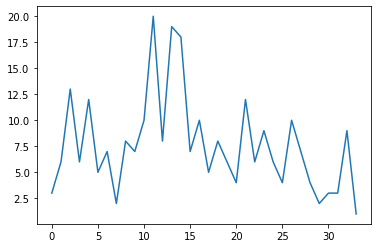

In [70]:
series_train = series.iloc[0: 30]
series_test = series.iloc[30:34]
plt.plot(series)

- We check if the time series is stationary with the adf test (**augmented Dickey-Fuller**).

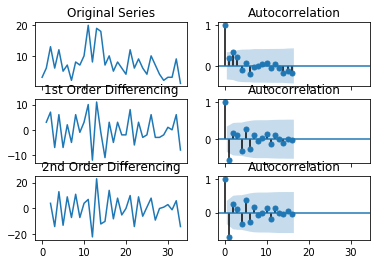

In [71]:
adfuller(series)[1]
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(series); axes[0, 0].set_title('Original Series')
plot_acf(series, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(series.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(series.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(series.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(series.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [72]:
adfuller(series.dropna())[1]

0.8937229830070468

In [73]:
adfuller(series.diff().dropna())[1]

1.2031138630103627e-08

- We obtain a **p-value** less than 0.05. So we can accept the alternative hypothesis, i.e the **time series is stationary**. 
- Now we are going to look at the coefficient related to the AR (autoregression model) which is usually denoted by p. 

Figure(432x288)


/Users/alessandrobiagi/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


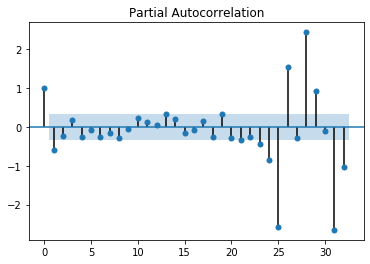

In [74]:
print(plot_pacf(series.diff().dropna(), lags = 32))

- We see that lag-1 is the only relevant value above the confidence region (the blue one). This means that a point in a time series is significantly correlated with the previous point
- The fact that is negative tell us that the if we see a value above the mean the next value will probably be under the mean (and vice-versa)
- Therefore, we decide to take the p coefficient equal to 1

- Now we look at the Moving Average (MA only) model in order to find the q coefficient

Figure(432x288)


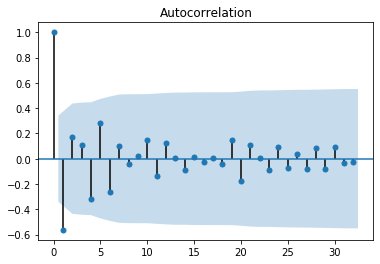

In [75]:
print(plot_acf(series.diff().dropna(), lags = 32))

- Also in this case we see that we have just one value above the blue region so we should take q = 1. 
- Considering that also the partial autocorrelation has a negative lag-1 we could also take q = 2, but we prefer being conservative in this case
- So we will try ARIMA(1,1,1).
- Let us plot the forcast vs the actual values.

In [76]:
model = ARIMA(series, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:         D.item_cnt_day   No. Observations:                   33
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -97.076
Method:                       css-mle   S.D. of innovations              4.549
Date:                Sun, 26 Jul 2020   AIC                            202.152
Time:                        13:56:16   BIC                            208.138
Sample:                             1   HQIC                           204.166
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0450      0.387     -0.116      0.907      -0.803       0.713
ar.L1.D.item_cnt_day    -0.3658      0.309     -1.184      0.237      -0.972       0.240
ma.L1.D.item

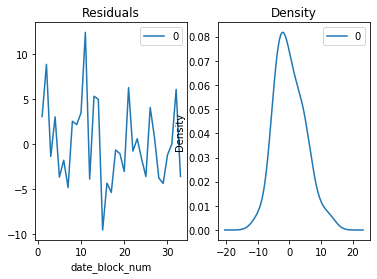

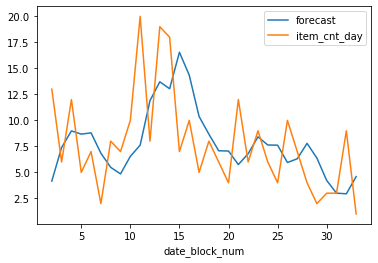

In [77]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

# In the folllowing graph we can see for every month what the model predicts using just
# the previous real point
model_fit.plot_predict(dynamic=False)
plt.show()

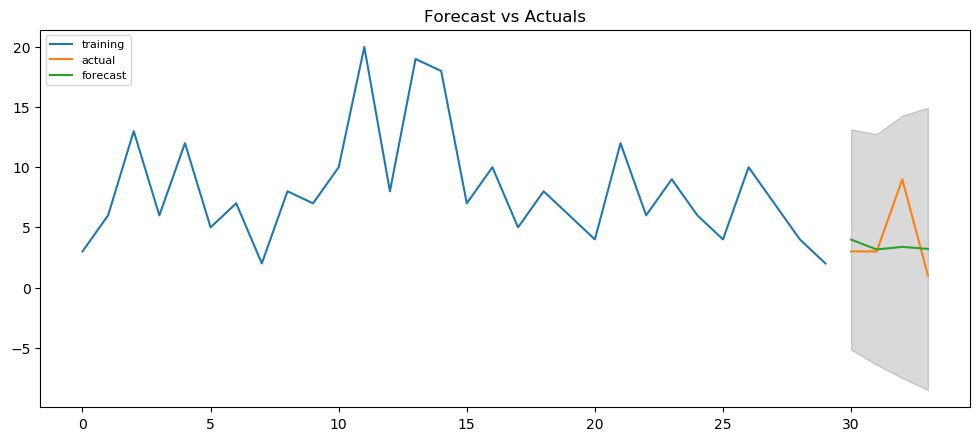

In [78]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(series_train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast for 4 points with a 95% confidence interval
fc, se, conf = fitted.forecast(4, alpha=0.05)

# Make as pandas series
fc_series = pd.Series(fc, index=series_test.index)
lower_series = pd.Series(conf[:, 0], index=series_test.index)
upper_series = pd.Series(conf[:, 1], index=series_test.index)

# In the folllowing graph we can see for every month what the model predicts using just
# the previous predicted point
plt.figure(figsize=(12,5), dpi=100)
plt.plot(series_train, label='training')
plt.plot(series_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Note that in this case we have predict the 4 next months using the previous 29 months. 

In [79]:
fc_series

date_block_num
30    3.984735
31    3.165637
32    3.379035
33    3.212222
dtype: float64

In [80]:
series_test

date_block_num
30    3.0
31    3.0
32    9.0
33    1.0
Name: item_cnt_day, dtype: float64

In [81]:
rmse = sum((t-p) ** 2 for t,p in zip(series_test, fc_series))/len(series_test)
print('The RMSE is: ', rmse)

9.371578555787567


- At this moment a possibility could be to try ARIMA(1,1,1) for every pair (shop_id, item_id) to really evaluate the performance, but we are not so confident that the same ARIMA model could adapt well
- Because of this, we decide to move forward with another strategy

- For sure this XGBoost strategy outperformed by far the Benchmark strategy since we have a **mean test score of 3.7096**
- Let's test its performance on the test set

# Strategy II: XGBoost

- This is our **most promising strategy**. For every row we create new features containing the item_cnt_day values of the months before
- With these features we train an XGBoost model. We hope that the model can learn some patterns between the amount of number of items sold in the previous months and the amount to predict.

In [146]:
df_xgb = df_merged.copy()
df_xgb.drop(['shop_name', 'item_category_name', 'item_name'], axis=1, inplace=True)
df_xgb = numeric_encoding(df_xgb, 'city')

In [147]:
df_xgb_lag = df_xgb.copy()
df_xgb_lag.head()

,shop_id,item_id,item_category_id,city,joined_fields,date_block_num,item_cnt_day,item_price
0,0,30,40,29,0_30,0,0.0,265.0
1,0,30,40,29,0_30,1,31.0,265.0
2,0,30,40,29,0_30,2,0.0,265.0
3,0,30,40,29,0_30,3,0.0,265.0
4,0,30,40,29,0_30,4,0.0,265.0


In [148]:
# We build the lag columns for the twelve months before
df_xgb_lag = building_unit_lags(df=df_xgb, df_lag=df_xgb_lag, pk='joined_fields',
                               time_col='date_block_num', value_col='item_cnt_day',
                               lag_size = 12)

In [149]:
df_xgb_lag.head()

,shop_id,item_id,item_category_id,city,joined_fields,date_block_num,item_cnt_day,item_price,item_cnt_day_lag_1,item_cnt_day_lag_2,item_cnt_day_lag_3,item_cnt_day_lag_4,item_cnt_day_lag_5,item_cnt_day_lag_6,item_cnt_day_lag_7,item_cnt_day_lag_8,item_cnt_day_lag_9,item_cnt_day_lag_10,item_cnt_day_lag_11,item_cnt_day_lag_12
0,0,30,40,29,0_30,0,0.0,265.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,30,40,29,0_30,1,31.0,265.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,30,40,29,0_30,2,0.0,265.0,31.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,30,40,29,0_30,3,0.0,265.0,0.0,31.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,30,40,29,0_30,4,0.0,265.0,0.0,0.0,31.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [150]:
df_xgb_lag.shape

(14420114, 20)

- We get rid of the null values in **item_cnt_day_lag_x** columns

In [151]:
df_xgb_lag = df_xgb_lag[df_xgb_lag['item_cnt_day_lag_12'].notna()]

In [152]:
df_xgb_lag.shape

(9330662, 20)

In [153]:
df_xgb_lag.head()

,shop_id,item_id,item_category_id,city,joined_fields,date_block_num,item_cnt_day,item_price,item_cnt_day_lag_1,item_cnt_day_lag_2,item_cnt_day_lag_3,item_cnt_day_lag_4,item_cnt_day_lag_5,item_cnt_day_lag_6,item_cnt_day_lag_7,item_cnt_day_lag_8,item_cnt_day_lag_9,item_cnt_day_lag_10,item_cnt_day_lag_11,item_cnt_day_lag_12
12,0,30,40,29,0_30,12,0.0,265.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,0.0
13,0,30,40,29,0_30,13,0.0,265.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0
14,0,30,40,29,0_30,14,0.0,265.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0,30,40,29,0_30,15,0.0,265.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0,30,40,29,0_30,16,0.0,265.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- Now we insert as column the item_price related to the previous month

In [154]:
df_xgb_lag = building_unit_lags(df=df_xgb_2, df_lag=df_xgb_lag, pk='joined_fields', 
                                time_col='date_block_num', value_col='item_price',
                                lag_size=1)

df_xgb_lag.drop(['item_price', 'joined_fields'], axis=1, inplace=True)
df_xgb_lag.head()

,shop_id,item_id,item_category_id,city,date_block_num,item_cnt_day,item_cnt_day_lag_1,item_cnt_day_lag_2,item_cnt_day_lag_3,item_cnt_day_lag_4,item_cnt_day_lag_5,item_cnt_day_lag_6,item_cnt_day_lag_7,item_cnt_day_lag_8,item_cnt_day_lag_9,item_cnt_day_lag_10,item_cnt_day_lag_11,item_cnt_day_lag_12,item_price_lag_1
0,0,30,40,29,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,0.0,265.0
1,0,30,40,29,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,265.0
2,0,30,40,29,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,265.0
3,0,30,40,29,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,265.0
4,0,30,40,29,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,265.0


- Before applying the XGBoost model, we perform a a **Features Importance phase** using Random Forest

## Features Importance and Selection

- **Due to our computational resources**, we take a modest subsample of our dataframe (only 5%). Since **item_cnt_day** has some members with only 1 representative, we cannot use a stratified method. We decide to proceed anyway using "sample"

In [155]:
df_xgb_lag_sampled = df_xgb_lag.sample(frac=0.05, random_state=123)
df_xgb_lag_sampled.shape

(466533, 19)

In [156]:
rfc_model = RandomForestRegressor(random_state=123)

z = df_xgb_lag_sampled.copy()
y = z['item_cnt_day']
X = z.drop('item_cnt_day', axis=1)

In [157]:
# We set our Recursive Features Elimination with Cross-Validation 
rfecv = RFECV(estimator=rfc_model, step=2, cv=KFold(n_splits=2, random_state=123, shuffle=True), 
              scoring='neg_mean_squared_error', n_jobs = -1, verbose=1)

In [ ]:
# We train our Random Forest
rfecv.fit(X, y)

In [ ]:
# We save rfecv to our directory
filename = 'models/saved_models/default_models/rfecv_xgb_2.sav'
rfecv = pickle.dump(rfecv, open(filename, 'rb'))

In [181]:
# We load rfecv from our directory
filename = 'models/saved_models/default_models/rfecv_xgb_2.sav'
rfecv = pickle.load(open(filename, 'rb'))

Optimal number of features : 6
Best features : Index(['item_id', 'date_block_num', 'item_cnt_day_lag_1', 'item_cnt_day_lag_3',
       'item_cnt_day_lag_7', 'item_cnt_day_lag_12'],
      dtype='object')
Original features : Index(['shop_id', 'item_id', 'item_category_id', 'city', 'date_block_num',
       'item_cnt_day_lag_1', 'item_cnt_day_lag_2', 'item_cnt_day_lag_3',
       'item_cnt_day_lag_4', 'item_cnt_day_lag_5', 'item_cnt_day_lag_6',
       'item_cnt_day_lag_7', 'item_cnt_day_lag_8', 'item_cnt_day_lag_9',
       'item_cnt_day_lag_10', 'item_cnt_day_lag_11', 'item_cnt_day_lag_12',
       'item_price_lag_1'],
      dtype='object')


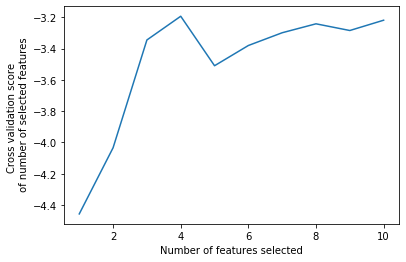

In [160]:
print("Optimal number of features : %d" % rfecv.n_features_)
print('Best features :', X.columns[rfecv.support_])
print('Original features :', X.columns)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score \n of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [161]:
print(rfecv.grid_scores_)
print(rfecv.ranking_)
print(rfecv.n_features_)
print(X.columns[rfecv.support_])
rfecv.estimator_.feature_importances_

[-4.45726619 -4.03420437 -3.34499195 -3.19328217 -3.50973636 -3.38033993
 -3.29880219 -3.24167012 -3.28449336 -3.21866431]
[4 1 5 4 1 1 2 1 5 6 2 1 3 7 7 6 1 3]
6
Index(['item_id', 'date_block_num', 'item_cnt_day_lag_1', 'item_cnt_day_lag_3',
       'item_cnt_day_lag_7', 'item_cnt_day_lag_12'],
      dtype='object')


array([0.15018611, 0.08485939, 0.18016362, 0.14377192, 0.16029711,
       0.28072185])

 We look at the variables eliminated at each step

In [162]:
num_feature = rfecv.n_features_
tab_general = pd.DataFrame ({ 'rank': rfecv.ranking_ , 'variables': X.columns.tolist()})
tab_rank = tab_general.copy()
tab_importances = tab_general.copy()

tab_rank = pd.DataFrame(tab_general.groupby('rank')['variables'].apply(list))

In [163]:
tab_rank

,variables
rank,
1,"[item_id, date_block_num, item_cnt_day_lag_1, ..."
2,"[item_cnt_day_lag_2, item_cnt_day_lag_6]"
3,"[item_cnt_day_lag_8, item_price_lag_1]"
4,"[shop_id, city]"
5,"[item_category_id, item_cnt_day_lag_4]"
6,"[item_cnt_day_lag_5, item_cnt_day_lag_11]"
7,"[item_cnt_day_lag_9, item_cnt_day_lag_10]"


We look at the importances for the final selected variables

In [164]:
tab_importances = tab_importances[tab_importances['rank']==1].drop('rank', axis = 1)
tab_importances['importances'] = rfecv.estimator_.feature_importances_
tab_importances.sort_values(by = 'importances', ascending = False, inplace = True)
tab_importances.reset_index(drop=True, inplace=True)

In [165]:
tab_importances

,variables,importances
0,item_cnt_day_lag_12,0.280722
1,item_cnt_day_lag_1,0.180164
2,item_cnt_day_lag_7,0.160297
3,item_id,0.150186
4,item_cnt_day_lag_3,0.143772
5,date_block_num,0.084859


## Applying XGBoost II

- Now we are ready to apply our XGBoost model
- We are going to train the model only for those pairs of (shop_id, item_id) that actually exist in our df_test

In [298]:
df_xgb_sel = df_xgb_lag.copy()
df_xgb_sel = df_xgb_sel[['item_id', 'shop_id', 'date_block_num', 'item_cnt_day_lag_1', 'item_cnt_day_lag_3',
                         'item_cnt_day_lag_7', 'item_cnt_day_lag_12', 'item_cnt_day']]
df_xgb_sel = joining_fields(df_xgb_sel, 'shop_id', 'item_id', 'joined_fields')
correct_rows=comparing_columns(df_test, df_xgb_sel, 'joined_fields', 'joined_fields')

False    6879774
True     2450888
Name: Match, dtype: int64


In [299]:
df_xgb_sel = df_xgb_sel[correct_rows]
df_xgb_sel.drop('Match', axis=1, inplace=True)

In [300]:
df_xgb_sel.shape

(2450888, 9)

In [301]:
df_xgb_sel.head()

,item_id,shop_id,date_block_num,item_cnt_day_lag_1,item_cnt_day_lag_3,item_cnt_day_lag_7,item_cnt_day_lag_12,item_cnt_day,joined_fields
134728,30,2,12,0.0,0.0,1.0,0.0,0.0,2_30
134729,30,2,13,0.0,0.0,0.0,0.0,0.0,2_30
134730,30,2,14,0.0,0.0,0.0,1.0,0.0,2_30
134731,30,2,15,0.0,0.0,0.0,0.0,1.0,2_30
134732,30,2,16,1.0,0.0,0.0,0.0,1.0,2_30


In [302]:
X_train_orig = df_xgb_sel.drop(['item_cnt_day', 'joined_fields'], axis=1).copy()
y_train_orig = df_xgb_sel['item_cnt_day'].values

In [303]:
xgb_2_default = regressor_gridCV(X_train_orig, y_train_orig, xgb.XGBRegressor(),
                                       model_name = "xgb_2_default")

/Users/alessandrobiagi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


The best parameters of grid are:  {} 
The best estimator is:  XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)


In [304]:
# We save the hyperparameters of the model
extracting_parameters_xgb(xgb_model=xgb_default.best_estimator_, model_name='xgb_default',
                          fields=['n_estimators', 'max_depth', 'learning_rate'])

# We save our model on disk
filename = "models/saved_models/xgb_default.sav"
pickle.dump(xgb_default, open(filename, 'wb'))

In [305]:
# We load our model from disk
filename = 'models/saved_models/default_models/xgb_default.sav'
xgb_default = pickle.load(open(filename, 'rb'))

We need to prepare the dataframe in the proper format in order to test our model

In [173]:
df_submission = df_test.copy()
df_submission = df_submission[['shop_id', 'item_id', 'joined_fields']]
df_submission['date_block_num'] = 34

In [174]:
for x in [33, 31, 27, 22]:
    rename_new = 'item_cnt_day_lag_' + str(34-x)
    df_submission = creating_submission_file(df_test=df_submission, df_xgb_sel=df_xgb_sel, month=x,
                                            rename_old='item_cnt_day', rename_new=rename_new)

In [175]:
df_submission.head()

,shop_id,item_id,joined_fields,date_block_num,item_cnt_day_lag_1,item_cnt_day_lag_3,item_cnt_day_lag_7,item_cnt_day_lag_12
0,5,5037,5_5037,34,0.0,3.0,0.0,1.0
1,5,5320,5_5320,34,NaN,NaN,NaN,NaN
2,5,5233,5_5233,34,1.0,1.0,0.0,0.0
3,5,5232,5_5232,34,0.0,1.0,0.0,0.0
4,5,5268,5_5268,34,NaN,NaN,NaN,NaN


In [176]:
df_submission = df_submission.drop('joined_fields', axis=1)
df_submission = df_submission[['item_id', 'shop_id', 'date_block_num', 'item_cnt_day_lag_1',
                              'item_cnt_day_lag_3', 'item_cnt_day_lag_7',
                               'item_cnt_day_lag_12']]
# We apply the model on our test dataset
predictions = xgb_default.predict(df_submission)

- We need to change properly the format of our test dataset to submit it on Kaggle
- In this way Kaggle will provide us the corresponding RMSE

In [177]:
df_submission_first = modifying_submission_format(df_submission=df_submission, predictions=predictions)[1]

In [178]:
df_submission_first

,ID,item_cnt_month
0,0,0.449307
1,1,0.093000
2,2,0.714514
3,3,0.328248
4,4,-0.045029
...,...,...
214195,214195,0.187474
214196,214196,-0.065330
214197,214197,0.173390
214198,214198,-0.176680


In [179]:
df_submission_first.to_csv('submissions/df_to_submit_first', index=False)

- We get an **RMSE** of 2.32279, so we improved significantly with respect to benchmark strategy

# Hyperparameter tuning

- The goal now is to take our xgboost model and to tune its hyperparameters to improve the performance
- We will use a fine to coarse approach with hyperopt. We cannot take into account a lot of parameters due to our limited computational resources

In [256]:
space = {
    'max_depth': hp.uniform ('max_depth', 12, 21),
    'learning_rate': hp.uniform('learning_rate', 0.12, 0.18),
    'n_estimators': hp.uniform('n_estimators', 65, 80)
}

In [257]:
# We define the loss to minimize
def objective(params):
    params_fun = {
        'max_depth': [int(params['max_depth'])],
        'learning_rate': [params['learning_rate']],
        'n_estimators': [int(params['n_estimators'])]
    }
    grid = GridSearchCV(xgb.XGBRegressor(), params_fun, scoring='neg_mean_squared_error', 
                        cv=StratifiedKFold(n_splits=5, shuffle=True, 
                                            random_state=42), 
                        n_jobs=-1)
    model = grid.fit(df_xgb_sel.drop('joined_fields', axis=1), df_xgb_sel['item_cnt_day'].values)
    mean_score = abs(model.cv_results_["mean_test_score"][0])
    return mean_score

In [258]:
current_time()

Current Time = 15:19:53


In [259]:
# We launch the search for the optimal hyperparameters
trials = Trials()
best_result = fmin(
             fn = objective,
             space = space,
             trials = trials,
             max_evals = 20,
             rstate = np.random.RandomState(42),
             algo = tpe.suggest)

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/Users/alessandrobiagi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)



  5%|▌         | 1/20 [10:15<3:14:58, 615.73s/trial, best loss: 0.04121973641223274]

/Users/alessandrobiagi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)



 10%|█         | 2/20 [22:47<3:16:59, 656.64s/trial, best loss: 0.025719213925694224]

/Users/alessandrobiagi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)



 15%|█▌        | 3/20 [36:20<3:19:20, 703.57s/trial, best loss: 0.025719213925694224]

/Users/alessandrobiagi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)



 20%|██        | 4/20 [48:26<3:09:20, 710.04s/trial, best loss: 0.025719213925694224]

/Users/alessandrobiagi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)



 25%|██▌       | 5/20 [1:00:57<3:00:38, 722.58s/trial, best loss: 0.025719213925694224]

/Users/alessandrobiagi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)



 30%|███       | 6/20 [1:13:38<2:51:16, 734.01s/trial, best loss: 0.025058987371743335]

/Users/alessandrobiagi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)



 35%|███▌      | 7/20 [1:26:24<2:41:07, 743.68s/trial, best loss: 0.025058987371743335]

/Users/alessandrobiagi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)



 40%|████      | 8/20 [1:37:43<2:24:50, 724.17s/trial, best loss: 0.025058987371743335]

/Users/alessandrobiagi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)



 45%|████▌     | 9/20 [1:49:01<2:10:15, 710.47s/trial, best loss: 0.023332544864882346]

/Users/alessandrobiagi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)



 50%|█████     | 10/20 [2:01:39<2:00:44, 724.45s/trial, best loss: 0.023332544864882346]

/Users/alessandrobiagi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)



 55%|█████▌    | 11/20 [2:12:00<1:44:00, 693.41s/trial, best loss: 0.023332544864882346]

/Users/alessandrobiagi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)



 60%|██████    | 12/20 [2:23:32<1:32:25, 693.19s/trial, best loss: 0.023332544864882346]

/Users/alessandrobiagi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)



 65%|██████▌   | 13/20 [2:35:21<1:21:25, 697.96s/trial, best loss: 0.023332544864882346]

/Users/alessandrobiagi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)



 70%|███████   | 14/20 [2:45:38<1:07:21, 673.53s/trial, best loss: 0.023332544864882346]

/Users/alessandrobiagi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)



 75%|███████▌  | 15/20 [2:58:04<57:57, 695.42s/trial, best loss: 0.023332544864882346]  

/Users/alessandrobiagi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)



 80%|████████  | 16/20 [3:09:48<46:31, 697.98s/trial, best loss: 0.023332544864882346]

/Users/alessandrobiagi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)



 85%|████████▌ | 17/20 [3:20:27<34:00, 680.06s/trial, best loss: 0.023332544864882346]

/Users/alessandrobiagi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)



 90%|█████████ | 18/20 [3:33:29<23:41, 710.81s/trial, best loss: 0.023283940801254736]

/Users/alessandrobiagi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)



 95%|█████████▌| 19/20 [3:45:51<12:00, 720.28s/trial, best loss: 0.023283940801254736]

/Users/alessandrobiagi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)



100%|██████████| 20/20 [3:58:46<00:00, 716.30s/trial, best loss: 0.023283940801254736]


In [260]:
current_time()

Current Time = 19:18:40


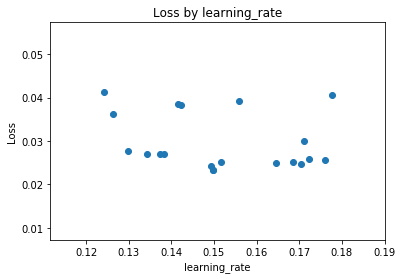

In [261]:
# learning_rate chart
parsing_trials_hp(trials=trials, field='learning_rate')

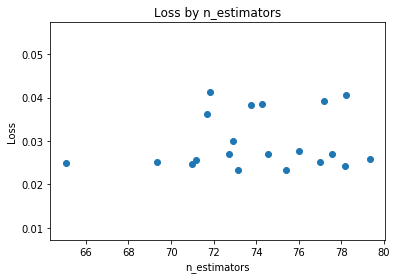

In [262]:
# n_estimators chart
parsing_trials_hp(trials=trials, field='n_estimators')

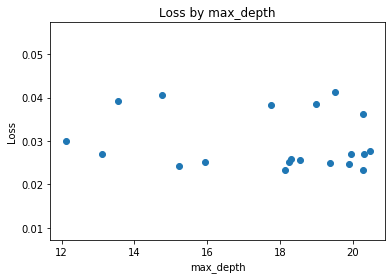

In [263]:
# max_depth chart
parsing_trials_hp(trials=trials, field='max_depth')

- The results are not so inspiring, probably we should take a larger space, but this is not feasible for computational resource
- The only thing appears to be clear is that a good value for the learning_rate is 0.15

In [269]:
depth = [t['misc']['vals']['max_depth'] for t in trials.trials]
trees = [t['misc']['vals']['n_estimators'] for t in trials.trials]
learning_rates = [t['misc']['vals']['learning_rate'] for t in trials.trials]
loss = [t['result']['loss'] for t in trials.trials] * 100

In [271]:
# We save the parameters
best_parameters_hp = pd.DataFrame({'max_depth':depth, 'n_estimators':trees, 
                                   'learning_rate':learning_rates, 'loss':loss}).sort_values(by='loss', ascending= True)
best_parameters_hp.to_csv('models/hyperparameters/best_parameters_hp', index=False)

In [272]:
print(best_parameters_hp.iloc[0])

max_depth        [18.129352121946425]
n_estimators      [75.38165678106904]
learning_rate    [0.1497186685159135]
loss                        0.0232839
Name: 17, dtype: object


In [287]:
parameters = {
    'learning_rate':[0.15],
    'n_estimators':[75, 70],
    'max_depth':[19, 18, 17]
    
}

In [288]:
current_time()

Current Time = 19:48:16


In [289]:
xgb_2_hyperopt = regressor_gridCV(X_train_orig, y_train_orig, xgb.XGBRegressor(),
                                       model_name = "xgb_hyperopt", params=parameters)

/Users/alessandrobiagi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


The best parameters of grid are:  {'learning_rate': 0.15, 'max_depth': 18, 'n_estimators': 75} 
The best estimator is:  XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.15, max_delta_step=0, max_depth=18,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=75, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)


In [290]:
current_time()

Current Time = 21:03:31


In [291]:
filename = "Models/saved_models/xgb_2_hyperopt.sav"
pickle.dump(xgb_2_hyperopt, open(filename, 'wb'))

In [292]:
filename = "Models/saved_models/xgb_2_hyperopt.sav"
xgb_2_hyperopt = pickle.load(open(filename, 'rb'))

In [293]:
df_submission_second = df_submission.copy()
df_submission_second.drop('item_cnt_month', axis=1, inplace=True)
df_submission_second = df_submission_second[['item_id', 'shop_id', 'date_block_num', 'item_cnt_day_lag_1', 
                                             'item_cnt_day_lag_3', 'item_cnt_day_lag_7',
                                             'item_cnt_day_lag_12']]

In [294]:
predictions = xgb_2_hyperopt.predict(df_submission_second)

In [295]:
df_submission_second = modifying_submission_format(df_submission=df_submission_second, predictions=predictions)[1]
df_submission_second.to_csv('submissions/df_to_submit_second', index=False)

In [296]:
current_time()

Current Time = 21:03:52


- Unfortunately we get a result of **RMSE 2.34264** when submitting the file
- Our model improved on the training set but it obtained worse results on the test set. Probably it overfitted a bit and the result got worse
- We could try to take a larger space with hyperopt, but this requires more computational power